In [141]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (12.0, 6.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

def fixedpoint(g, x0, tol=1.e-10, max_iter=30):
    ''' Solve x=g(x) by fixed point iterations
        The output of each iteration is printed
    Input:
        g:   The function g(x)
        x0:  Initial values
        tol: The tolerance
    Output:
        The root and the number of iterations
    '''
    x = x0
    for k in range(max_iter):        
        x_old = x                        # Store old values for error estimation 
        x = g(x)                         # The iteration
        err = abs(x-x_old)               # Error estimate
        if err < tol:                    # The solution is accepted
            break
    print(f"k ={k+1:3d}, x = {x:14.10f}")
    return x, k+1

In [130]:
#parametre
sigma0 = 1000 # vanns massetetthet
sigma = 500 # skipets massetetthet
R = 10 # skipets radius
As = 1/2*np.pi*R**2 # skipets tverrsnittsareal
m = As*sigma # skipets masse
IC = 1/2*m*R**2*(1-32/(9*np.pi**2)) # Skipets treghetsmoment
g = 9.81 # Tyngdeakselerasjonen
FG = -m*g # Tyngdekraften
h = 4*R/(3*np.pi) # Avstanden mellom skipets massesenter og metasenteret

def sector(beta):
    return np.sin(beta) + np.pi*sigma/sigma0

beta, steps = fixedpoint(sector, 2.3, max_iter=50)
'''vinkelen som beskriver hvor mye av skipet som er i kontakt med vann ved likevekt er beta. Når skipet
 (er på vei til å)synke(r) er den pi og vi ser at det er beta og ikke beta/2 som er den etterspurte
 vinkelen fra ligningen for sektorvolumet, blant annet'''

yM0 = R*np.cos(beta/2) # skipets metasenter
yC0 = yM0-h # Høyden til massesenteret ved likevekt
yD0 = yM0 -R  # Skipets dypeste punkt
YMB0 = R*(4*(np.sin(beta/2))**3)/(3*(beta-np.sin(beta)))
yB0 = yM0-YMB0 # angrepspunktet til oppdriftskraften

k =  0, x =   2.3000000000
k = 49, x =   2.3098814600


$
\Sigma \tau=I_c \frac{d\omega}{dt} \qquad (13)\\
\vec w = \left( \begin{array}{c} w_1 \\ w_2\end{array} \right) = 
\left( \begin{array}{c}\theta(t) \\ \omega(t) \end{array} \right)
$

Siden vi kun ser på dreiemoment fra oppdriften er $\Sigma \tau = -F_B h \sin(\theta(t))$, og derfor gir (13):
$\frac{d\omega}{dt} = \frac{-F_B h \sin(\theta(t))}{I_c} $
$
\\ \frac{d\vec w}{dt}(t) = \vec{f}(t,\vec{w}) = 
\left( \begin{array}{c} w_2 \\ \frac{-F_B h \sin( w_1)}{I_c} \end{array} \right) =
\left( \begin{array}{c} \omega(t) \\ \frac{-F_B h \sin(\theta(t))}{I_c} \end{array} \right)
$

In [131]:
def w_deriv_1(t, w): #Dette er f(t, w(t)) fra 1c
    dw = np.array([[w[1]], [FG*h*np.sin(w[0])/IC]]) # Oppdriftskraften er lik minus tyngdekraften i oppgave 1
    return dw

def w_deriv_1_approx(t, w): #Dette er f(t, w(t)) fra 1e
    dw = np.array([[w[1]], [FG*h*w[0]/IC]]) # Bruker small angle approx
    return dw

def euler_method(w0, T_start, T_slutt, h_step, f = w_deriv_1):
    """
    Beregner utslagsvinkelen theta og vinkelhastigheten omega utfra initialverdiene og til T sekunder

    theta_0: utslagsvinkel ved start
    omega_0: vinkelhastighet ved start
    dt: tidssteg
    """
    dT = T_slutt - T_start
    n = int(dT//h_step)        # Antall steg
    last_step = T_slutt-n*h_step
    w = np.array(([[], []]), dtype = '<f')
    t = np.linspace(T_start, T_slutt-last_step, n + 1)
    t = np.append(t, [float(T_slutt)])
    w = np.concatenate((w, w0), axis = 1)
    for i in range(n+1):           # for-loop over alle verdier f.o.m. 0, til n
        if i == n:
            h_step = last_step
            deriv = h_step*f(t[i], [w[0][i], w[1][i]])
            step = [w[0][i]+deriv[0], w[1][i]+deriv[1]]
            w = np.concatenate((w, np.array([step[0], step[1]])), axis = 1)
            # Passer på at vi alltid avslutter på nøyaktig t = T_slutt
        else:
            deriv = h_step*f(t[i], [w[0][i], w[1][i]])
            step = [w[0][i]+deriv[0], w[1][i]+deriv[1]]
            w = np.concatenate((w, np.array([step[0], step[1]])), axis = 1) # Beregner ett steg med Eulers metode
        
    return w, t

def rk4(ti, wi, h_step, f=w_deriv_1):
    k1 = f(ti, wi)
    k2 = f(ti + h_step/2, [wi[0]+h_step/2*k1[0][0], wi[1]+h_step/2*k1[1][0]])
    k3 = f(ti + h_step/2, [wi[0]+h_step/2*k2[0][0], wi[1]+h_step/2*k2[1][0]])
    k4 = f(ti + h_step, [wi[0]+h_step*k3[0][0], wi[1]+h_step*k3[1][0]])
    step = [[h_step/6*(k1[0][0] + 2*k2[0][0] + 2*k3[0][0] +k4[0][0])], [h_step/6*(k1[1][0] + 2*k2[1][0] + 2*k3[1][0] +k4[1][0])]]
    return step

def rk4_method(w0, T_start, T_slutt, h_step, f = w_deriv_1):
    """
    Beregner utslagsvinkelen theta og vinkelhastigheten omega utfra initialverdiene og til T sekunder

    theta_0: utslagsvinkel ved start
    omega_0: vinkelhastighet ved start
    dt: tidssteg
    """
    dT = T_slutt - T_start
    n = int(dT//h_step)        # Antall steg
    last_step = T_slutt-n*h_step
    w = np.array(([[], []]), dtype = '<f')
    t = np.linspace(T_start, T_slutt-last_step, n + 1)
    t = np.append(t, [float(T_slutt)])
    w = np.concatenate((w, w0), axis = 1)
    for i in range(n+1):           # for-loop over alle verdier f.o.m. 0, til n
        if i == n:
            h_step = last_step
            deriv = rk4(t[i], [w[0][i], w[1][i]], h_step, f)
            step = [w[0][i]+deriv[0], w[1][i]+deriv[1]]
            w = np.concatenate((w, np.array([step[0], step[1]])), axis = 1)
            # Passer på at vi alltid avslutter på nøyaktig t = T_slutt
        else:
            deriv = rk4(t[i], [w[0][i], w[1][i]], h_step, f)
            step = [w[0][i]+deriv[0], w[1][i]+deriv[1]]
            w = np.concatenate((w, np.array([step[0], step[1]])), axis = 1) # Beregner ett steg med RK4 metode
        
    return w, t

Avviket ved 20 grader er: 2.9877e+00 grader.


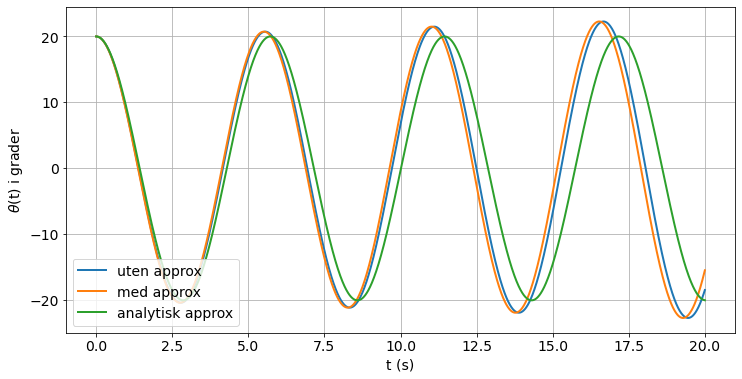

Avviket ved 1 grad er:  4.1594e-04 grader


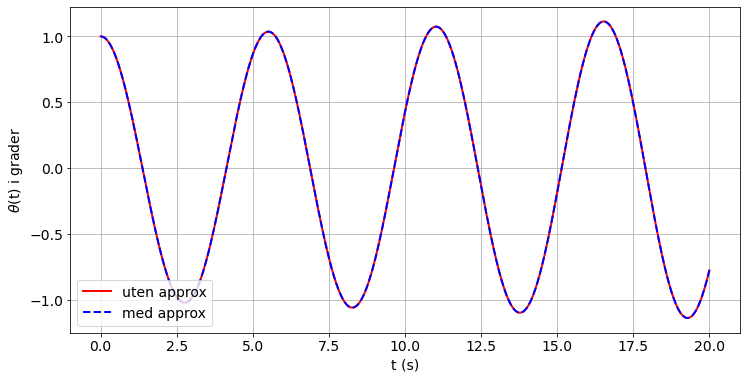

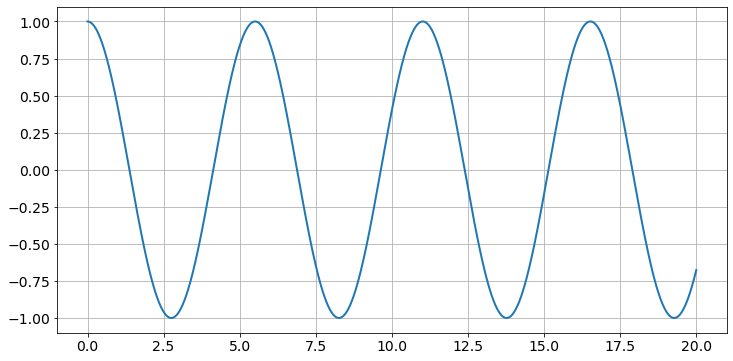

In [195]:
h_step= 0.01

vinkel = 20
w0 = np.array([[vinkel*np.pi/180],[0]])


w, t = euler_method(w0, 0, 20, h_step)
w_sa, t_sa = euler_method(w0, 0, 20, h_step, f = w_deriv_1_approx)

plt.plot(t, w[0]*180/np.pi, label = 'uten approx')
plt.plot(t_sa, w_sa[0]*180/np.pi, label = 'med approx')
plt.plot(t, vinkel*np.cos(np.sqrt(m*g*h/IC)*t), label = 'analytisk approx') #plotter analytisk løsning av lign (10)

print(f'Avviket ved 20 grader er: {(w_sa[0][-1]-w[0][-1])*180/np.pi:.4e} grader.')

plt.ylabel(r'$\theta$(t) i grader')
plt.xlabel('t (s)')
plt.legend(loc = 3)
plt.show()

vinkel = 1
w0 = np.array([[vinkel*np.pi/180],[0]])


w, t = euler_method(w0, 0, 20, h_step)
w_sa, t_sa = euler_method(w0, 0, 20, h_step, f = w_deriv_1_approx)



print(f'Avviket ved 1 grad er:  {(w_sa[0][-1]-w[0][-1])*180/np.pi:.4e} grader')

plt.plot(t, w[0]*180/np.pi, 'r-', label = 'uten approx')
plt.plot(t_sa, w_sa[0]*180/np.pi, 'b--', label = 'med approx')

plt.ylabel(r'$\theta$(t) i grader')
plt.xlabel('t (s)')
plt.legend(loc = 3)
plt.show()


w_rk, t_rk = rk4_method(w0, 0, 20, h_step, f = w_deriv_1_approx)
plt.plot(t_rk, w_rk[0]*180/np.pi, label = 'med approx')

Vi velger en steglengde på 0.001 da dette ser ut til å gi realistiske resultater basert på at vinkelutslaget øker veldig lite over tid med 0.001 som steglengde, og også gir lignende resultater. Med 0.01 som steglengde ser vi tydelig at vinkelutslaget øker, noe som er ufysisk, men ellers gir også en steglengde på 0.01 akseptable resultater. Forskjellen beregningene med og uten tilnærming ved 20 grader med begge steglengdene varierer med ca. 0.02 så vi får gode resultater med 0.01 som steglengde. Vi konkluderer med at vi foretrekker en steglengde på 0.001, men kan akseptere steglengde på 0.01 og helst ikke (mye) mer, da atferden med lengre steglengder blir dårlig (store økninger i vinkelutslag).

Vi ser fra plottene at approksimasjonen $sin(\theta) \approx \theta$ er visualt identisk over 20 sekunder til plottet uten approksimasjon (avvik på $4.16\cdot10^{-4}$ grader) , mens vi ser et lite avvik visuelt ved 20 grader (avvik på $2.99$ grader). Fra dette kan vi konkludere at tilnærmingen er veldig god ved vinkler på rundt 1 grad, og akseptabel ved 20 grader om vi tolererer feil i størrelsesordenen 0.05 grader.

Analytisk løsning på ligning (10) er 
$ \quad -mgh\theta = I_C\ddot{\theta} \quad => \tilde{\theta} = cos\left(\sqrt{\frac{mhg}{I_C}} t + \phi\right) \\$.
Der $\phi$ er et ledd som forskyver fasen til $\tilde{\theta}$ slik at vi tar høyde for en vinkelhastighet ved start. $\phi = 0$ om $\omega(t=0)=0$

In [206]:
def w_deriv_last(t, w, vx, xC, vy, yC, sL, vL, beta_last, h_step): # Dette er f fra 2d
    dt = h_step # tidssteg
    theta = w[0]
    dyC = yC-yC0 # delta yC
    gamma = 2*np.arccos(np.cos(beta_last/2)-4/(3*np.pi)*(1-np.cos(theta))+dyC/R)
    A = R**2/2*(gamma-np.sin(gamma))
    vx += (mL*g*np.cos(theta)*np.sin(theta))*dt/mtot
    xC_new = xC + vx*dt
    vy += (A*sigma0*g-m*g -mL*g*(np.cos(theta))**2)*dt/mtot
    yC_new = yC + vy*dt # Skipets nye x og y koordinater
    vL += -g*np.sin(theta)*dt
    sL += vL*dt # Finner lastens avstand fra metasenteret
    domega = (-A*sigma0*g*h*np.sin(theta)-mL*g*np.cos(theta)*sL)/IC
    dw = np.array([[w[1]], [domega]]) # Bruker small angle approx
    return dw, vx, xC_new, vy, yC_new, sL, vL

def rk4_multi(ti, wi, vx, xC, vy, yC, sL, vL, beta_last, h_step, f=w_deriv_last):
    k1 = f(ti, wi, vx, xC, vy, yC, sL, vL, beta_last, h_step)[0]
    k2 = f(ti + h_step/2, [wi[0]+h_step/2*k1[0][0], wi[1]+h_step/2*k1[1][0]], vx, xC, vy, yC, sL, vL, beta_last, h_step)[0]
    k3 = f(ti + h_step/2, [wi[0]+h_step/2*k2[0][0], wi[1]+h_step/2*k2[1][0]], vx, xC, vy, yC, sL, vL, beta_last, h_step)[0]
    k4 = f(ti + h_step, [wi[0]+h_step*k3[0][0], wi[1]+h_step*k3[1][0]], vx, xC, vy, yC, sL, vL, beta_last, h_step)[0]
    step = [[h_step/6*(k1[0][0] + 2*k2[0][0] + 2*k3[0][0] +k4[0][0])], [h_step/6*(k1[1][0] + 2*k2[1][0] + 2*k3[1][0] +k4[1][0])]]
    return step

def rk4_method_last(w0, T_start, T_slutt, h_step, yC0, sL = 0,vx=0, vy=0, xC = 0, vL = 0, f = w_deriv_last, gjerde = False, kantring = True):
    """
    Beregner utslagsvinkelen theta og vinkelhastigheten omega utfra initialverdiene og til T sekunder

    theta_0: utslagsvinkel ved start
    omega_0: vinkelhastighet ved start
    dt: tidssteg
    """
    dT = T_slutt - T_start
    n = int(dT//h_step)        # Antall steg
    last_step = T_slutt-n*h_step
    w = np.array(([[], []]), dtype = '<f')
    t = np.linspace(T_start, T_slutt-last_step, n + 1)
    t = np.append(t, [float(T_slutt)])
    w = np.concatenate((w, w0), axis = 1)
    sL_list = np.array([sL])
    yC = yC0
    xC_list, yC_list = np.array([xC]), np.array([yC])
    for i in range(n+1):           # for-loop over alle verdier f.o.m. 0, til n
        dyC = yC - yC0
        _, vx, xC, vy, yC, sL, vL = f(t, [w[0][i], w[1][i]], vx, xC, vy, yC, sL, vL, beta_last, h_step)
        sL_list = np.append(sL_list, [sL])
        xC_list = np.append(xC_list, [xC])
        yC_list = np.append(yC_list, [yC])
        if abs(sL)>R: # Sjekker om lasten er på bord
            mL = 0
            IC = 1/2*m*R**2*(1-32/(9*np.pi**2))
            FG = -mtot*g
            gamma = 2*np.arccos(np.cos(beta/2)-4/(3*np.pi)*(1-np.cos(w[0][i]))+dyC/R)
            _, vx, xC, vy, yC, _, _ = f(t, [w[0][i], w[1][i]], vx, xC, vy, yC, sL, vL, beta_last, h_step)
            yM0 = R*np.cos(beta/2)
            yC0 = yM0-h
            if gjerde:
                sL_list[-1] = np.sign(sL_list[-2])*R
                vL = 0
            else:    
                sL_list[-1] = np.sign(sL_list[-2])*2*R
        if kantring:
            if abs(w[0][i])>(np.pi-2*np.arccos(np.cos(beta_last/2)-4/(3*np.pi)*(1-np.cos(w[0][i]))+dyC/R))/2:
                # Ser om skipet kantrer
                w = np.concatenate((w, np.array([[np.sign(w[0][i])*np.pi/2], [0]])), axis = 1)
                if i == n:
                    return w, t, sL_list, xC_list, yC_list
                continue
        if i == n:
            h_step = last_step
            deriv = rk4_multi(t[i], [w[0][i], w[1][i]], vx, xC, vy, yC, sL, vL, beta_last, h_step, f)
            step = [w[0][i]+deriv[0], w[1][i]+deriv[1]]
            w = np.concatenate((w, np.array([step[0], step[1]])), axis = 1)
            # Passer på at vi alltid avslutter på nøyaktig t = T_slutt
        else:
            deriv = rk4_multi(t[i], [w[0][i], w[1][i]], vx, xC, vy, yC, sL, vL, beta_last, h_step, f)
            step = [w[0][i]+deriv[0], w[1][i]+deriv[1]]
            w = np.concatenate((w, np.array([step[0], step[1]])), axis = 1) # Beregner ett steg med RK4 metode
        
    return w, t, sL_list, xC_list, yC_list

Utregning av beta der vi tar høyde for lasten
k = 43, x =   2.3108198323
-20.0


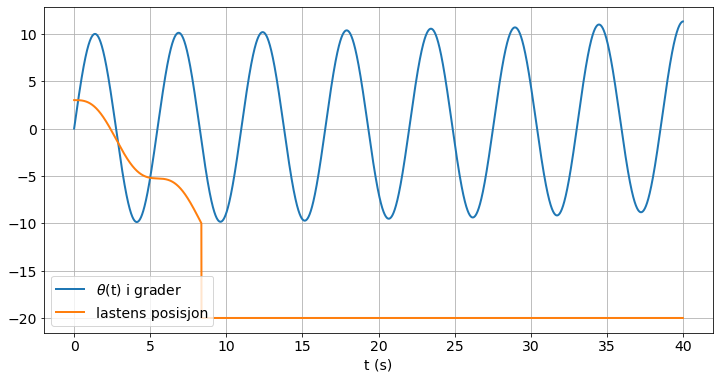

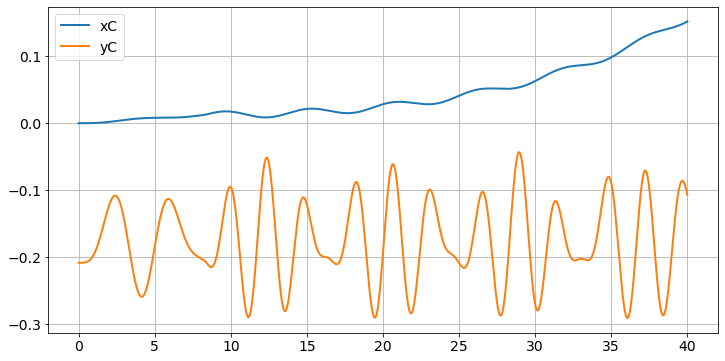

Utregning av beta der vi tar høyde for lasten
k = 50, x =   2.3837883121
-20.0


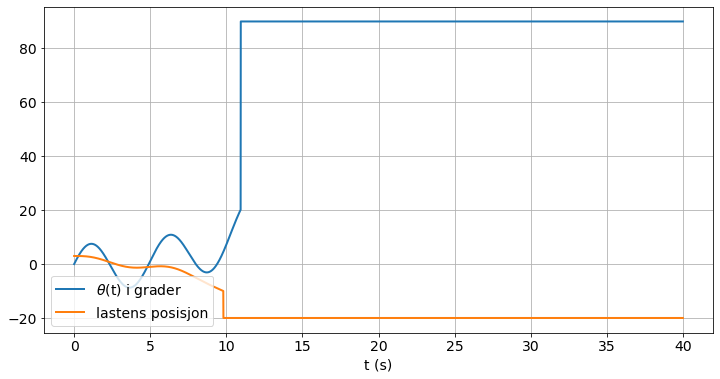

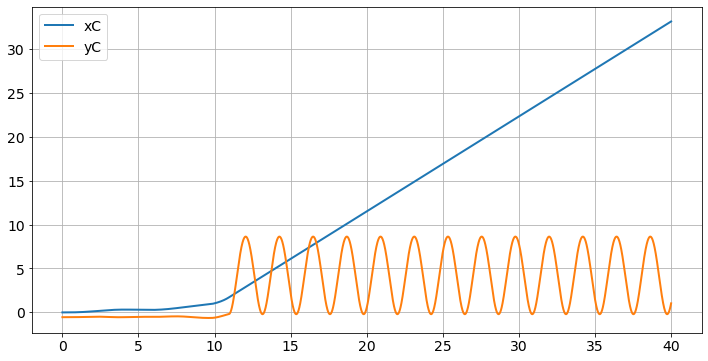

In [207]:
theta0, omega0, sL0 = 0, 0.2, 3
w0 = np.array([[theta0],[omega0]])
h_step= 0.005


# nye parametre
last_ratio = 0.001
mL = m*last_ratio
mtot = m + mL
IC = 1/2*mtot*R**2*(1-32/(9*np.pi**2)) # Skipets treghetsmoment
FG = -mtot*g # Tyngdekraften

def sector_last(beta_last):
    return np.sin(beta_last) + np.pi*sigma*(1+last_ratio)/sigma0

print('Utregning av beta der vi tar høyde for lasten')
beta_last, steps_last = fixedpoint(sector_last, 2.31, max_iter=50)


yM0 = R*np.cos(beta_last/2) # skipets metasenter
yC0 = yM0-h # Høyden til massesenteret ved likevekt


w_last, t, sL, xC, yC = rk4_method_last(w0, 0, 40, h_step, yC0, sL = sL0)
print(sL[-1])
plt.plot(t, w_last[0]*180/np.pi, label = r'$\theta$(t) i grader')
plt.plot(t, sL, label = 'lastens posisjon')

plt.xlabel('t (s)') # Plotter
plt.legend(loc = 3)
plt.show()

plt.plot(t, xC, label = 'xC')
plt.plot(t, yC, label = 'yC')
plt.legend()
plt.show()

########################## neste masse ################################


# nye parametre
last_ratio = 0.08
mL = m*last_ratio
mtot = m + mL
IC = 1/2*mtot*R**2*(1-32/(9*np.pi**2)) # Skipets treghetsmoment
FG = -mtot*g # Tyngdekraften

def sector_last(beta_last):
    return np.sin(beta_last) + np.pi*sigma*(1+last_ratio)/sigma0

print('Utregning av beta der vi tar høyde for lasten')
beta_last, steps_last = fixedpoint(sector_last, 2.31, max_iter=50)
yM0 = R*np.cos(beta_last/2) # skipets metasenter
yC0 = yM0-h # Høyden til massesenteret ved likevekt


w_last, t, sL, xC, yC = rk4_method_last(w0, 0, 40, h_step, yC0, sL = sL0)
print(sL[-1])
plt.plot(t, w_last[0]*180/np.pi, label = r'$\theta$(t) i grader')
plt.plot(t, sL, label = 'lastens posisjon')

plt.xlabel('t (s)') # Plotter
plt.legend(loc = 3)
plt.show()

plt.plot(t, xC, label = 'xC')
plt.plot(t, yC, label = 'yC')
plt.legend()
plt.show()

In [192]:
def w_deriv_full(t, w, xC, yC, sL, vL, beta_last, h_step): # Dette er f fra 2d
    dt = h_step # tidssteg
    theta = w[0]
    dyC = yC-yC0 # delta yC
    gamma = 2*np.arccos(np.cos(beta_last/2)-4/(3*np.pi)*(1-np.cos(theta))+dyC/R)
    A = R**2/2*(gamma-np.sin(gamma))
    xC_new = xC + (mL*g*np.cos(theta)*np.sin(theta))*dt**2/m
    yC_new = yC + (A*sigma0*g-m*g -mL*g*(np.cos(theta))**2)*dt**2/m # Skipets nye x og y koordinater
    vL += g*np.sin(theta)*dt
    sL += vL*dt # Finner lastens avstand fra metasenteret
    domega = (-A*sigma0*g*h*np.sin(theta)-mL*g*np.cos(theta)*sL)/IC
    dw = np.array([[w[1]], [domega]]) # Bruker small angle approx
    return dw, xC_new, yC_new, sL, vL